In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df = pd.read_csv(
    "electricity.csv",
    low_memory=False
)
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)
df = df.drop("Date", axis=1)
df = df.drop("Time", axis=1)
df = df.set_index("datetime")
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
#checkimg null values
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


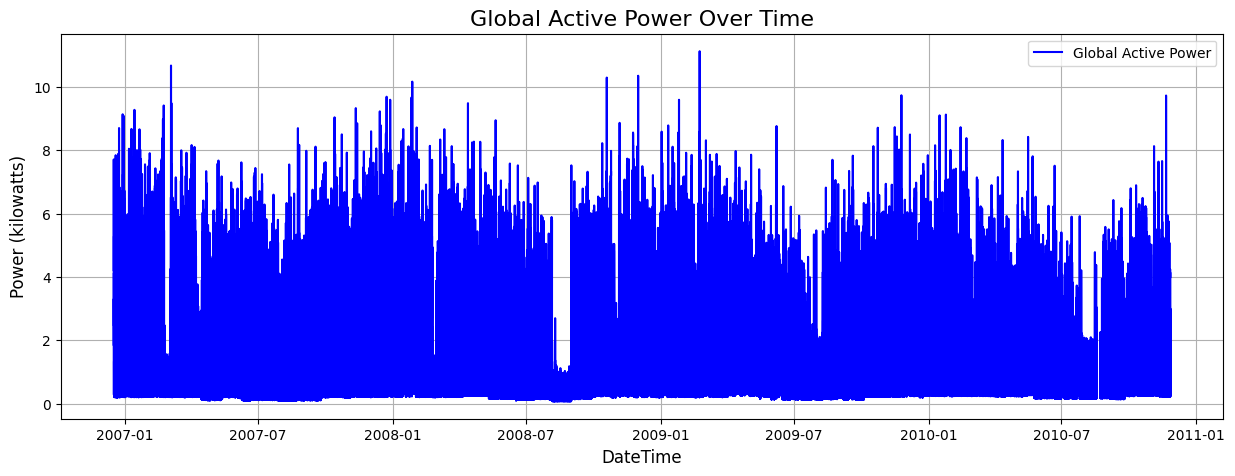

/tmp/ipython-input-171107608.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['Global_active_power'].resample('M').mean()
/tmp/ipython-input-171107608.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total = df['Global_active_power'].resample('M').sum()


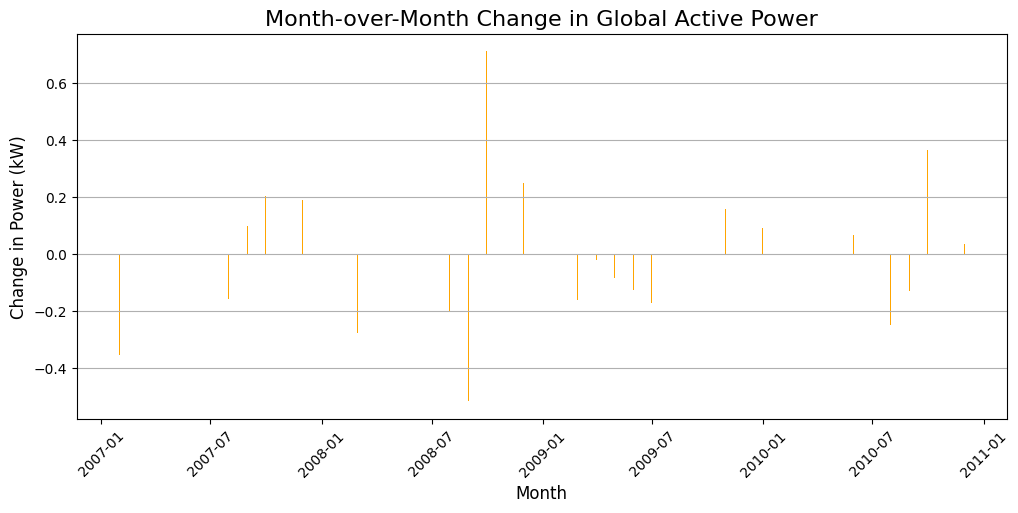

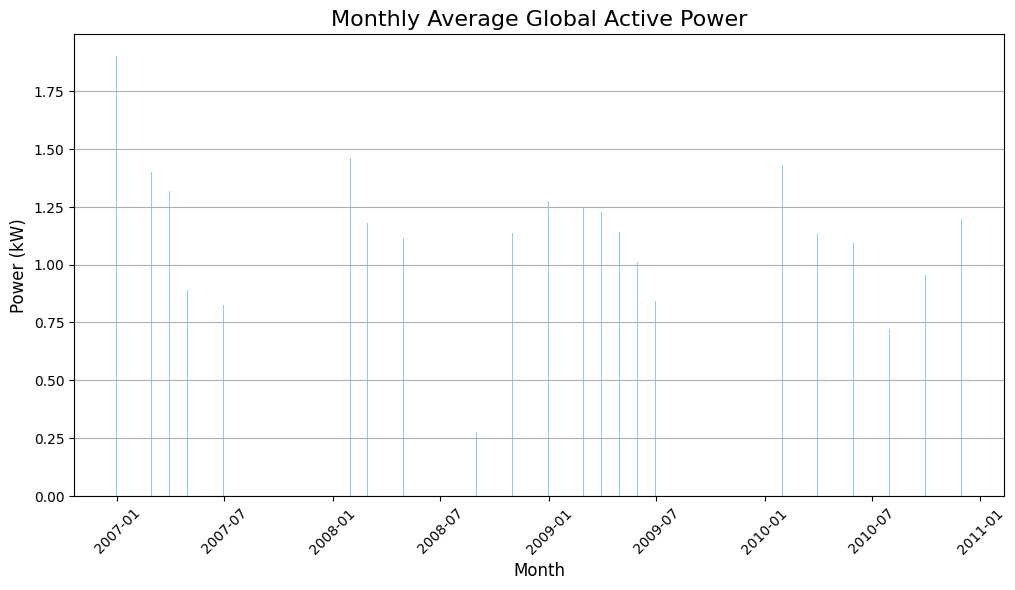

In [ ]:
#exploratory data analysis
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power', color='blue')
plt.title('Global Active Power Over Time', fontsize=16)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Power (kilowatts)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

monthly_avg = df['Global_active_power'].resample('M').mean()
monthly_change = monthly_avg.diff()  # difference between consecutive months
monthly_total = df['Global_active_power'].resample('M').sum()

plt.figure(figsize=(12,5))
plt.bar(monthly_change.index, monthly_change, color='orange')
plt.title('Month-over-Month Change in Global Active Power', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Change in Power (kW)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(monthly_avg.index, monthly_avg, color='skyblue')  # use monthly_total if you want total usage
plt.title('Monthly Average Global Active Power', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
#testing importing strategies
df_sample = df.sample(100000, random_state = 42).copy()
numeric_cols = df_sample.select_dtypes(include=np.number).columns
#simulate missingness on known columns
df_missing = df_sample.copy()
mask = np.random.rand(*df_missing[numeric_cols].shape) < 0.1
df_missing.loc[:, numeric_cols] = df_missing[numeric_cols].mask(mask)
#ground truth
true_values = df_sample[numeric_cols][mask]

#1 median
df_median = df_missing.fillna(df_missing.median(numeric_only=True))

#2 interpolation
df_interp = df_missing.copy()
df_interp[numeric_cols] = df_interp[numeric_cols].interpolate(
    method="time",
    limit_direction="both"
)

# 3. hybrid (Median first, then Time Interpolation)
df_hybrid = df_missing.copy()

# Step 1: fill big holes with median
df_hybrid[numeric_cols] = df_hybrid[numeric_cols].fillna(
    df_missing[numeric_cols].median()
)

# Step 2: smooth over with time interpolation
df_hybrid[numeric_cols] = df_hybrid[numeric_cols].interpolate(
    method="time",
    limit_direction="both"
)

print("NaNs in ground truth:", true_values.isna().sum().sum())
print("NaNs in Median imput:", df_median[numeric_cols].isna().sum().sum())
print("NaNs in Interp imput:", df_interp[numeric_cols].isna().sum().sum())
print("NaNs in Hybrid imput:", df_hybrid[numeric_cols].isna().sum().sum())

def evaluate(imputed, name):
    pred_values = imputed[numeric_cols][mask].to_numpy().ravel()
    true_vals   = true_values.to_numpy().ravel()

    # Stack both to drop rows where either side is NaN
    both = np.vstack([true_vals, pred_values]).T
    both = both[~np.isnan(both).any(axis=1)]

    if both.shape[0] == 0:
        return {"Method": name, "RMSE": np.nan, "MAE": np.nan}

    rmse = mean_squared_error(both[:, 0], both[:, 1]) ** 0.5
    mae = mean_absolute_error(both[:, 0], both[:, 1])
    return {"Method": name, "RMSE": rmse, "MAE": mae}


results = []
results.append(evaluate(df_median, "Median"))
results.append(evaluate(df_interp, "Interpolation"))
results.append(evaluate(df_hybrid, "Hybrid (Median + Time Interp)"))

# 5. Compare results
print(results)
results_df = pd.DataFrame(results)
print(results_df)

NaNs in ground truth: 5964
NaNs in Median imput: 0
NaNs in Interp imput: 0
NaNs in Hybrid imput: 0
[{'Method': 'Median', 'RMSE': 2.6631735590682775, 'MAE': 0.5046812977138645}, {'Method': 'Interpolation', 'RMSE': 1.6154562104774344, 'MAE': 0.22557535372350843}, {'Method': 'Hybrid (Median + Time Interp)', 'RMSE': 2.6631735590682775, 'MAE': 0.5046812977138645}]
                          Method      RMSE       MAE
0                         Median  2.663174  0.504681
1                  Interpolation  1.615456  0.225575
2  Hybrid (Median + Time Interp)  2.663174  0.504681


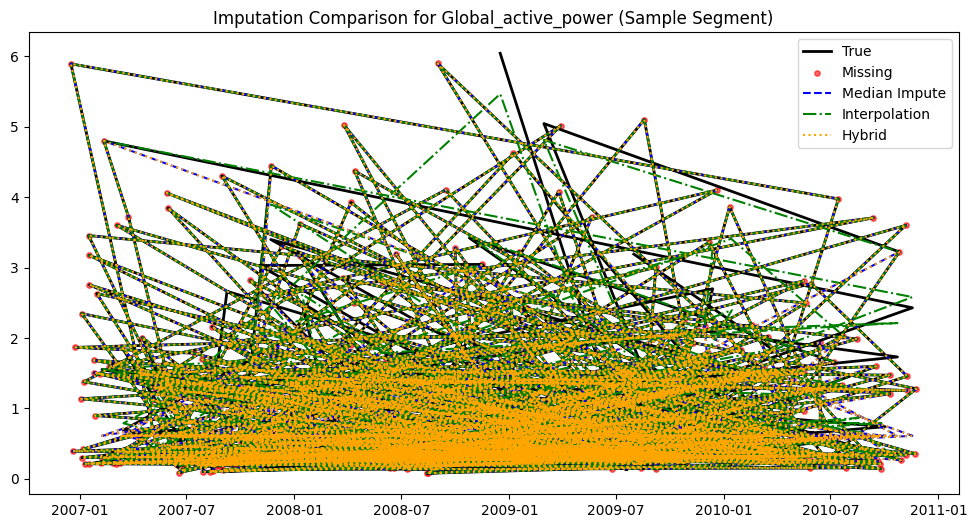

/tmp/ipython-input-570033693.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


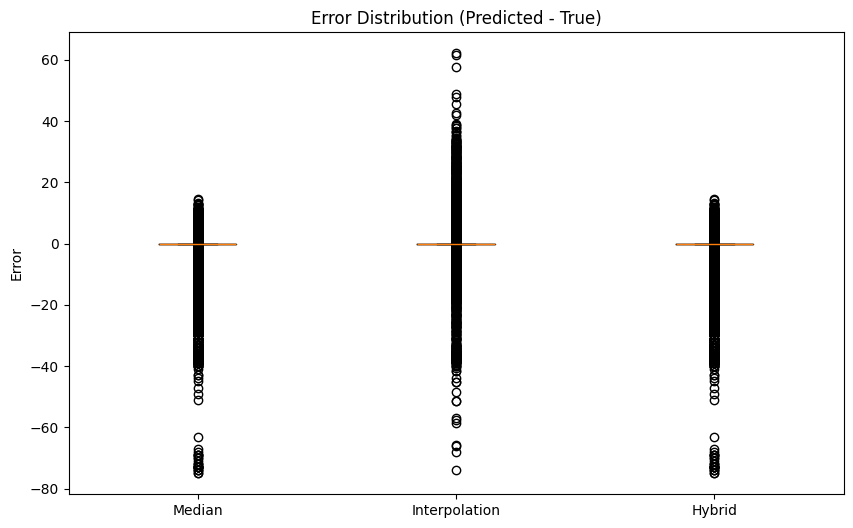

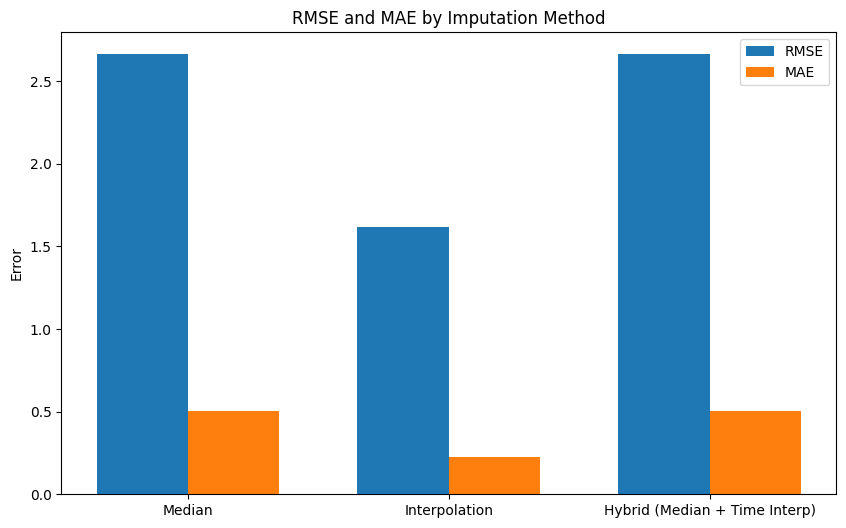

In [ ]:
import matplotlib.pyplot as plt

# --------------------------
# 1. Sample Segment Plot
# --------------------------
# Pick one numeric column and a short time window
col = numeric_cols[0]
segment = df_sample[col].iloc[:500]   # first 500 rows (adjust as needed)

missing_segment = df_missing[col].iloc[:500]
median_segment = df_median[col].iloc[:500]
interp_segment = df_interp[col].iloc[:500]
hybrid_segment = df_hybrid[col].iloc[:500]

plt.figure(figsize=(12,6))
plt.plot(segment.index, segment, label="True", color="black", linewidth=2)
plt.scatter(missing_segment.index, missing_segment, label="Missing", color="red", s=15, alpha=0.6)
plt.plot(median_segment.index, median_segment, label="Median Impute", color="blue", linestyle="--")
plt.plot(interp_segment.index, interp_segment, label="Interpolation", color="green", linestyle="-.")
plt.plot(hybrid_segment.index, hybrid_segment, label="Hybrid", color="orange", linestyle=":")
plt.legend()
plt.title(f"Imputation Comparison for {col} (Sample Segment)")
plt.show()


# --------------------------
# 2. Error Distribution
# --------------------------
median_errors = (df_median[numeric_cols] - df_sample[numeric_cols]).values.flatten()
interp_errors = (df_interp[numeric_cols] - df_sample[numeric_cols]).values.flatten()
hybrid_errors = (df_hybrid[numeric_cols] - df_sample[numeric_cols]).values.flatten()

plt.figure(figsize=(10,6))
plt.boxplot(
    [median_errors[~np.isnan(median_errors)],
     interp_errors[~np.isnan(interp_errors)],
     hybrid_errors[~np.isnan(hybrid_errors)]],
    labels=["Median", "Interpolation", "Hybrid"]
)
plt.title("Error Distribution (Predicted - True)")
plt.ylabel("Error")
plt.show()


# --------------------------
# 3. RMSE & MAE Bar Chart
# --------------------------
x = np.arange(len(results_df))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, results_df["RMSE"], width, label="RMSE")
plt.bar(x + width/2, results_df["MAE"], width, label="MAE")
plt.xticks(x, results_df["Method"])
plt.ylabel("Error")
plt.title("RMSE and MAE by Imputation Method")
plt.legend()
plt.show()


In [ ]:
#feature engineering
#1 lag features
df['lag1h'] = df['Global_active_power'].shift(60)
df['lag2h'] = df['Global_active_power'].shift(120)
df['lag3h'] = df['Global_active_power'].shift(180)
df['lag24h'] = df['Global_active_power'].shift(24*60)
df['lag7d'] = df['Global_active_power'].shift(24*60*7)
#2 rolling features
df['rolling_mean_1h'] = df['Global_active_power'].rolling(window=60).mean()
df['rolling_mean_24h'] = df['Global_active_power'].rolling(window=1440).mean()
df['rolling_mean_7d'] = df['Global_active_power'].rolling(window=10080).mean()
df['rolling_std_1h'] = df['Global_active_power'].rolling(window=60).std()
df['rolling_min_1h'] = df['Global_active_power'].rolling(window=60).min()
df['rolling_max_1h'] = df['Global_active_power'].rolling(window=60).max()
df['rolling_std_24h'] = df['Global_active_power'].rolling(window=1440).std()
df['rolling_min_24h'] = df['Global_active_power'].rolling(window=1440).min()
df['rolling_max_24h'] = df['Global_active_power'].rolling(window=1440).max()
df['rolling_std_7d'] = df['Global_active_power'].rolling(window=10080).std()
df['rolling_min_7d'] = df['Global_active_power'].rolling(window=10080).min()
df['rolling_max_7d'] = df['Global_active_power'].rolling(window=10080).max()
df.tail()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,lag1h,lag2h,lag3h,...,rolling_mean_7d,rolling_std_1h,rolling_min_1h,rolling_max_1h,rolling_std_24h,rolling_min_24h,rolling_max_24h,rolling_std_7d,rolling_min_7d,rolling_max_7d
datetime,,,,,,,,,,,,,,,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,1.526,1.626,1.052,...,1.150144,0.312391,0.908,2.3,0.803781,0.214,4.242,1.001591,0.21,9.724
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0,1.524,1.610,1.062,...,1.150057,0.310324,0.908,2.3,0.803756,0.214,4.242,1.001571,0.21,9.724
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,1.456,1.810,1.096,...,1.149960,0.309258,0.908,2.3,0.803733,0.214,4.242,1.001544,0.21,9.724
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0,1.554,1.844,1.094,...,1.149846,0.306044,0.908,2.3,0.803712,0.214,4.242,1.001503,0.21,9.724
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0,1.596,1.876,1.086,...,1.149816,0.301420,0.908,2.3,0.803693,0.214,4.242,1.001505,0.21,9.724


/tmp/ipython-input-1461560614.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_trend = df['rolling_mean_1h'].resample('H').mean()


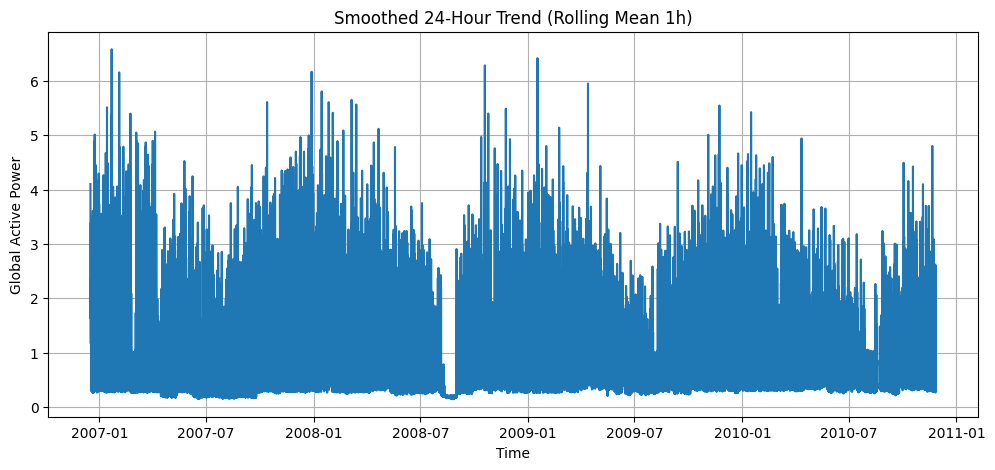

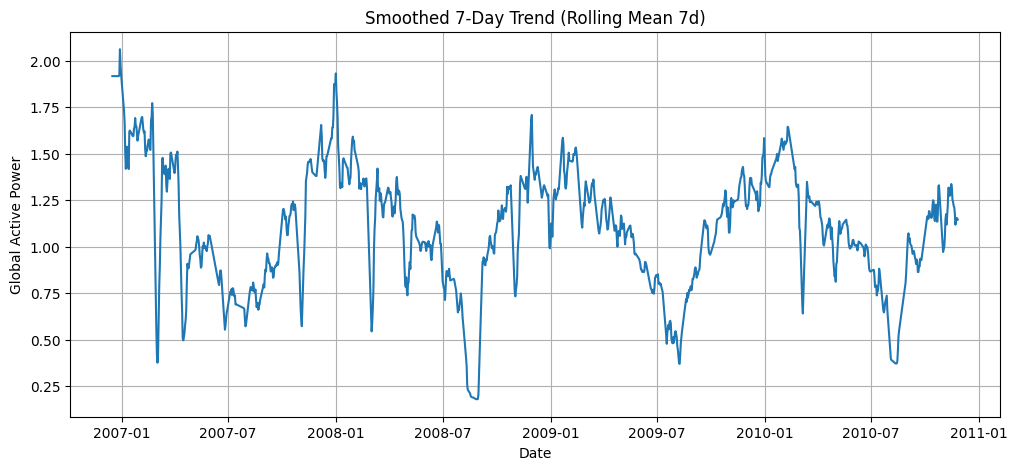

In [ ]:
hourly_trend = df['rolling_mean_1h'].resample('H').mean()
plt.figure(figsize=(12,5))
plt.plot(hourly_trend.index, hourly_trend.values)
plt.title('Smoothed 24-Hour Trend (Rolling Mean 1h)')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.grid(True)
plt.show()

weekly_trend = df['rolling_mean_7d'].resample('D').mean()

plt.figure(figsize=(12,5))
plt.plot(weekly_trend.index, weekly_trend.values)
plt.title('Smoothed 7-Day Trend (Rolling Mean 7d)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.grid(True)
plt.show()

In [ ]:
#interpolate again
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 2. Interpolate missing values (for both target and features)
df[numeric_cols] = df[numeric_cols].interpolate(
    method='time',         # use datetime index
    limit_direction='both' # fill NaNs at start and end
)

# 3. Optional: backfill any remaining NaNs just to be safe
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# 4. Verify
print("Remaining NaNs in df:", df.isna().sum().sum())

/tmp/ipython-input-2473414262.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-2473414262.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Remaining NaNs in df: 0


In [ ]:
#test train split
# 1. Separate features and target
X = df.drop('Global_active_power', axis=1)
y = df['Global_active_power']

# 2. Split by index (time-based)
train_size = 0.8
split_idx = int(len(df) * train_size)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test  = X.iloc[split_idx:]
y_test  = y.iloc[split_idx:]

In [ ]:
#training xgBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # regression
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Evaluation set
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Train model
num_round = 500
model = xgb.train(
    params,
    dtrain,
    num_round,
    evals=evallist,
    early_stopping_rounds=50,
    verbose_eval=10
)

# Predict
y_pred = model.predict(dtest)

# Regression metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R2  : {r2:.5f}")


[0]	train-rmse:0.98226	eval-rmse:0.79478
[10]	train-rmse:0.35095	eval-rmse:0.27976
[20]	train-rmse:0.13564	eval-rmse:0.10620
[30]	train-rmse:0.05939	eval-rmse:0.04805
[40]	train-rmse:0.03973	eval-rmse:0.03539
[50]	train-rmse:0.03444	eval-rmse:0.03258
[60]	train-rmse:0.03228	eval-rmse:0.03152
[70]	train-rmse:0.03121	eval-rmse:0.03093
[80]	train-rmse:0.03048	eval-rmse:0.03068
[90]	train-rmse:0.02994	eval-rmse:0.03052
[100]	train-rmse:0.02949	eval-rmse:0.03037
[110]	train-rmse:0.02915	eval-rmse:0.03027
[120]	train-rmse:0.02887	eval-rmse:0.03023
[130]	train-rmse:0.02859	eval-rmse:0.03015
[140]	train-rmse:0.02835	eval-rmse:0.03008
[150]	train-rmse:0.02818	eval-rmse:0.03000
[160]	train-rmse:0.02799	eval-rmse:0.02993
[170]	train-rmse:0.02782	eval-rmse:0.02993
[180]	train-rmse:0.02762	eval-rmse:0.02988
[190]	train-rmse:0.02750	eval-rmse:0.02986
[200]	train-rmse:0.02738	eval-rmse:0.02984
[210]	train-rmse:0.02727	eval-rmse:0.02981
[220]	train-rmse:0.02715	eval-rmse:0.02976
[230]	train-rmse:0.027

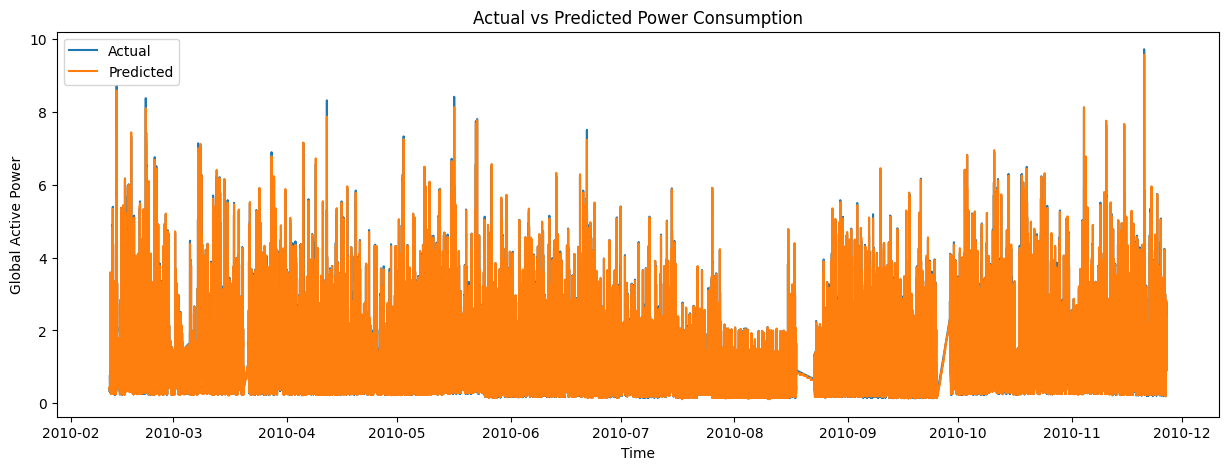

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.title('Actual vs Predicted Power Consumption')
plt.legend()
plt.show()


In [ ]:
new_row = {}

# Raw features: take the last available values
for col in ['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']:
    new_row[col] = df[col].iloc[-1]

# Lag features
new_row['lag1h']  = df['Global_active_power'].iloc[-60]
new_row['lag2h']  = df['Global_active_power'].iloc[-120]
new_row['lag3h']  = df['Global_active_power'].iloc[-180]
new_row['lag24h'] = df['Global_active_power'].iloc[-1440]
new_row['lag7d']  = df['Global_active_power'].iloc[-10080]

# Rolling features
new_row['rolling_mean_1h'] = df['Global_active_power'].iloc[-60:].mean()
new_row['rolling_mean_24h'] = df['Global_active_power'].iloc[-1440:].mean()
new_row['rolling_mean_7d'] = df['Global_active_power'].iloc[-10080:].mean()
new_row['rolling_std_1h'] = df['Global_active_power'].iloc[-60:].std()
new_row['rolling_min_1h'] = df['Global_active_power'].iloc[-60:].min()
new_row['rolling_max_1h'] = df['Global_active_power'].iloc[-60:].max()
new_row['rolling_std_24h'] = df['Global_active_power'].iloc[-1440:].std()
new_row['rolling_min_24h'] = df['Global_active_power'].iloc[-1440:].min()
new_row['rolling_max_24h'] = df['Global_active_power'].iloc[-1440:].max()
new_row['rolling_std_7d'] = df['Global_active_power'].iloc[-10080:].std()
new_row['rolling_min_7d'] = df['Global_active_power'].iloc[-10080:].min()
new_row['rolling_max_7d'] = df['Global_active_power'].iloc[-10080:].max()

# Create DataFrame
X_new = pd.DataFrame([new_row], index=[predict_time])

# Predict
y_pred = model.predict(xgb.DMatrix(X_new))[0]
print(f"Predicted Global_active_power at {predict_time}: {y_pred:.3f} kW")

Predicted Global_active_power at 2025-09-01 15:00:00: 0.906 kW
